In [1]:
using Plots
using StatsBase
using Statistics
pyplot()

using DSP

include("ARMA_Generator.jl")
include("wiener_filter_scalar.jl")

wiener_filter (generic function with 1 method)

In [2]:
# Graph stuff
Nex = 2^10;
Theta = 2pi*(0:Nex)/Nex;
Z = map(th -> exp(im*th),Theta);

So far it was tested with 

`
steps = 10^4
discard = 10^3
l = [1, -5/4, 3/8]
pred = ARMA_gen(l, steps = steps)
w = [1, -5/3, 4, -20/3];
sig = ARMA_gen([],w, steps = steps);
`

And with 

`
steps = 10^4
discard = 10^3
Zeros = [-.2im .2im .8]
Poles = [.5im -.5im .6]
pred = ARMA_gen(Zeros = Zeros, Poles = Poles, steps = steps, discard = discard)
Zeros = [.8]
Poles = [.33im -.33im .2]
sig = ARMA_gen(Zeros = Zeros, Poles = Poles, steps = steps, discard = discard)
`

Then with 

`
steps = 10^4
discard = 10^3
p, q = 5 , 6
Zeros_pred = 1 .- rand(q)*2
Poles_pred = 1 .- rand(p)*2
pred = ARMA_gen(Zeros = Zeros_pred, Poles = Poles_pred, steps = steps, discard = discard)
p, q = 3 , 6
Zeros_sig = 1 .- rand(q)*2
Poles_sig = 1 .- rand(p)*2
sig = ARMA_gen(Zeros = Zeros_sig, Poles = Poles_sig, steps = steps, discard = discard)
`

Here we build WSS processes to test the WF.

In [3]:
steps = 10^6
discard = 5*10^3

p, q, r = 3 , 3 , 1.0
Zeros_sig = [] #1 .- rand(q)*2
Poles_sig = [-.2, .6] #1 .- rand(p)*2
sig = ARMA_gen([1], r = r, Zeros = Zeros_sig, Poles = Poles_sig, steps = steps, discard = discard)
sig_test = ARMA_gen([1],r = r, Zeros = Zeros_sig, Poles = Poles_sig, steps = steps, discard = discard);

P_sig = prod([Poly([1]); [Poly([1,-z]) for z in Poles_sig]])
Q_sig = prod([Poly([1]); [Poly([1,-z]) for z in Zeros_sig]])
tranfer_fun(z) = Q_sig(z^(-1))/P_sig(z^(-1))
z_spect_sig_ana(z) = abs(tranfer_fun(z))^2

z_spect_sig_ana (generic function with 1 method)

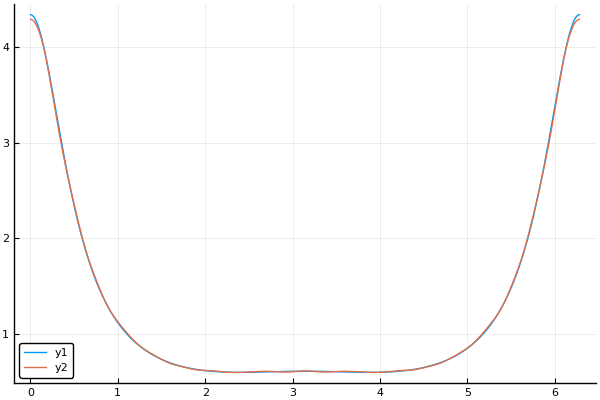

In [4]:
par = 55

z_spect_sig_num = z_spect(sig,par, win = "Par");

plot(Theta, [z_spect_sig_ana.(Z) real.(z_spect_sig_num.(Z))])

In [5]:
eps = 1
w = [1, -5/4, 3/8]
pred = conv(w,sig)[discard + 1 : steps] .+ eps*randn(steps-discard);
sig = sig[discard + 1 : steps];
pred_test = conv(w,sig_test)[discard + 1 : steps] .+ eps*randn(steps-discard);
sig_test = sig_test[discard + 1 : steps];

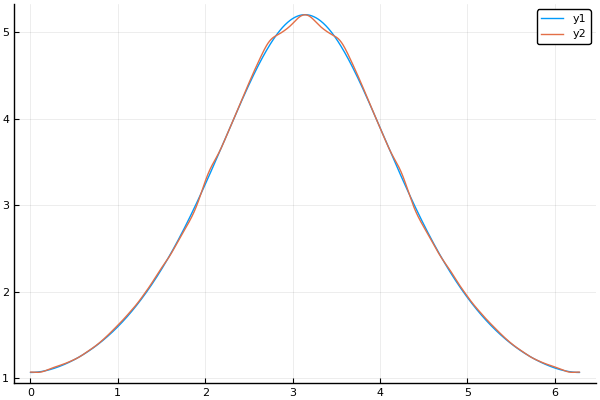

In [6]:
W(z) = Poly(w)(z^(-1));
z_spect_pred_ana(z) = W(z)*z_spect_sig_ana(z)*conj(W(conj(z)^(-1))) + eps

z_spect_pred_num = z_spect(pred,par, win = "Par");

plot(Theta, [real.(z_spect_pred_ana.(Z)) real.(z_spect_pred_num.(Z))])

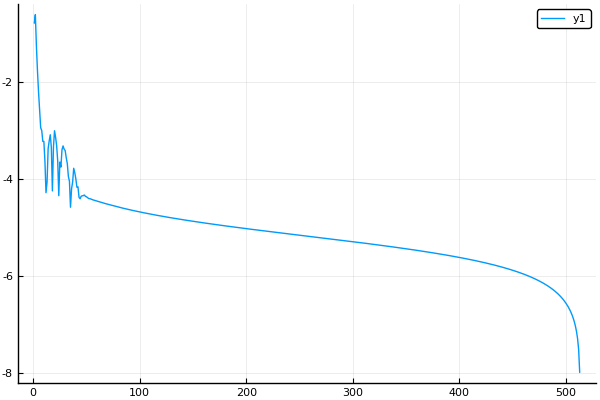

In [7]:
h = wiener_filter_Nu(pred, sig)

h = real.(h);
plot(log.(abs.(h))/log(10))

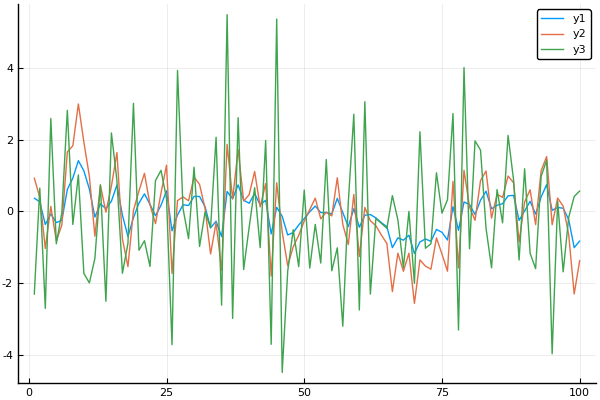

In [8]:
hh = LPC.lpc(sig,100)

tim = 1:100
sig_hat_lpc = -conv(hh[1],sig)[1:steps-discard]

plot([sig_hat_lpc[tim] sig[tim] pred[tim]])

### Estimated Signal by Wiener Filter

In [9]:
sig_hat = conv(h,pred_test)[discard + 1:steps-discard];

In [10]:
Error = sig_hat .- sig_test[discard + 1:steps-discard]

990000-element Array{Float64,1}:
 -0.5782553381289977 
  0.14691189871283794
  1.719326057562573  
  2.055903857231184  
 -0.21265319364021096
  0.08897580985082076
  1.6275449014731964 
  1.5916529793153669 
  0.2957256277296511 
  0.28234440907334946
  2.432147897378308  
  1.6027954814931524 
  0.3491721416221303 
  ⋮                  
 -0.8528884880631218 
 -0.3450231718816416 
 -0.1803919683026995 
  0.19896149396533444
  0.37035479692044815
 -0.6488599142623419 
 -0.6033570405558383 
 -0.7946129816109891 
 -0.44064112357384094
  0.9380604610148944 
  0.8884592303875412 
  2.0698939356430275 

In [11]:
print("Absolute mean square error: ",mean(abs.(Error)))
start = steps - discard - 100
stop = steps - discard
tim = start : stop
plot([-sig_hat_lpc[tim] sig_hat[tim] sig_test[tim]])

Absolute mean square error: 0.9654798652668589

BoundsError: BoundsError: attempt to access 990000-element Array{Float64,1} at index [994900:995000]

### Test Orthogonality with Predictors

The Wiener filter, by virture of it being a least squares estimator will produce a prediction errors $Y_n - \hat{Y}_n$ -> `sig[n] - sig_hat[n]` that is uncorrolated with the predictors used $X_m$ -> `pred[m]` for $m \le n$. 

       Before lag = 0          |      after lag = 0 
mean:     -0.12559090931983033 | mean:     0.054618220588269914
variance: 0.06593391866809165 | variance: 0.03648150114344265

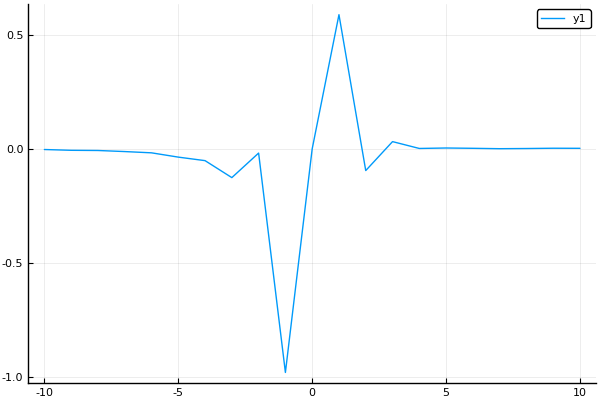

In [12]:
lag = 10
lags = -lag:lag

C = crosscov(Error,pred_test[discard + 1:steps-discard],lags);
print("       Before lag = 0          |      after lag = 0 ",
    "\nmean:     ", mean(C[1:lag]), " | mean:     ", mean(C[lag+2:end]),
    "\nvariance: ", var(C),         " | variance: ", var(C[lag+2:end]))
plot(lags,C)